#Imports & Environment

In [1]:
# Imports
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Load environment 
load_dotenv()
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "mobilebank")
DB_USER = os.getenv("DB_USER", "postgres")
DB_PASSWORD = os.getenv("DB_PASSWORD", "8075")


#Connect to PostgreSQL

In [2]:
# Connect to PostgreSQL
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

print("✔ Connected to PostgreSQL")


✔ Connected to PostgreSQL


#Load CSV

In [3]:
# Load final-review.csv
df = pd.read_csv(r"C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\reviews_with_sentiment.csv")
print(f"Loaded {len(df)} reviews")
df.head()


Loaded 960 reviews


,review_id,review_text,rating,review_date,bank_code,bank_name,user_name,thumbs_up,reply_content,source,clean_review,compound,sentiment,clean_text
0,1,Very disappointing application. it's getting w...,1,2025-10-31 19:25:05,DASHEN,Dashen Bank,A.Senay ZENEBE,0,NaN,PlayStore,very disappointing application. it's getting w...,-0.7956,Negative,very disappointing application. it's getting w...
1,2,"Banking made simple, smart, and safe.",5,2025-10-28 15:35:23,DASHEN,Dashen Bank,Bilen Atinafe,0,NaN,PlayStore,"banking made simple, smart, and safe.",0.6808,Positive,"banking made simple, smart, and safe."
2,3,It is the best of all i liked it i used it alm...,5,2025-10-27 19:37:55,DASHEN,Dashen Bank,Guta Gundo,0,NaN,PlayStore,it is the best of all i liked it i used it alm...,0.8519,Positive,it is the best of all i liked it i used it alm...
3,4,gngu,5,2025-10-21 00:31:58,DASHEN,Dashen Bank,Yalelet Ahmed,0,NaN,PlayStore,gngu,0.0000,Neutral,gngu
4,5,"The app is very good , but it does not tell th...",4,2025-09-09 22:24:44,DASHEN,Dashen Bank,Esrael Worku,0,NaN,PlayStore,"the app is very good , but it does not tell th...",0.7504,Positive,"the app is very good , but it does not tell th..."


#Create Tables

In [4]:
from sqlite3 import OperationalError


try:
    engine = create_engine(
        f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    )
    connection = engine.connect()
    print("✔ Connected to PostgreSQL")
except OperationalError as e:
    print("❌ Connection failed. Check your PostgreSQL credentials and server status.")
    print(e)
    exit()

✔ Connected to PostgreSQL


#: Insert Banks

In [12]:
from sqlalchemy import text

# ---------------------------
# 1. Detect the correct bank column
# ---------------------------
possible_cols = ["bank", "bank_name", "banks"]

bank_col = None
for col in possible_cols:
    if col in df.columns:
        bank_col = col
        break

if bank_col is None:
    raise KeyError("No valid bank column found! Expected one of: bank, bank_name, banks")

print(f"✔ Using column '{bank_col}' as bank name")

# ---------------------------
# 2. Insert unique banks
# ---------------------------
banks = df[bank_col].dropna().unique()

with engine.begin() as conn:
    for bank in banks:
        conn.execute(
            text("""
                INSERT INTO banks (bank_name, app_name)
                VALUES (:bank_name, :app_name)
                ON CONFLICT (bank_name) DO NOTHING;
            """),
            {
                "bank_name": bank,
                "app_name": f"{bank} Mobile Banking App"
            }
        )

    # ---------------------------
    # 3. Fetch bank_id mapping
    # ---------------------------
    result = conn.execute(text("SELECT bank_id, bank_name FROM banks;"))
    bank_map = {row[1]: row[0] for row in result}  # row[1]=bank_name, row[0]=bank_id

print("✔ Inserted banks successfully")
print(bank_map)


✔ Using column 'bank_name' as bank name
✔ Inserted banks successfully
{'Dashen Bank': 10, 'Commercial Bank of Ethiopia': 11, 'Abyssinia Bank': 12}


#Insert Reviews

In [ ]:
from sqlalchemy import text

# ----------------------------------------------------
# 1. Detect bank column (same as in Insert Banks)
# ----------------------------------------------------
possible_bank_cols = ["bank", "bank_name", "banks"]
bank_col = None

for col in possible_bank_cols:
    if col in df.columns:
        bank_col = col
        break

if bank_col is None:
    raise KeyError("Bank column not found. Expected one of: bank, bank_name, banks")

print(f"✔ Using bank column: {bank_col}")

# ----------------------------------------------------
# 2. Detect sentiment label column
# ----------------------------------------------------
possible_sentiment_cols = ["sentiment_label", "sentiment", "label"]
sentiment_col = None

for col in possible_sentiment_cols:
    if col in df.columns:
        sentiment_col = col
        break

if sentiment_col is None:
    print("⚠ No sentiment label column found. Setting sentiment_label = None for all rows.")

# ----------------------------------------------------
# 3. Detect sentiment score column
# ----------------------------------------------------
possible_score_cols = ["sentiment_score", "score", "polarity"]
score_col = None

for col in possible_score_cols:
    if col in df.columns:
        score_col = col
        break

if score_col is None:
    print("⚠ No sentiment score column found. Setting sentiment_score = None for all rows.")

# ----------------------------------------------------
# 4. Insert reviews safely
# ----------------------------------------------------
with engine.begin() as conn:
    for _, row in df.iterrows():

        # Lookup bank_id safely
        bank_name = row[bank_col]
        bank_id = bank_map.get(bank_name)

        if bank_id is None:
            print(f"⚠ Skipping review — bank not found in mapping: {bank_name}")
            continue

        conn.execute(
            text("""
                INSERT INTO reviews 
                (bank_id, review_text, rating, review_date, sentiment_label, sentiment_score, source)
                VALUES (:bank_id, :review_text, :rating, :review_date, :sentiment_label, :sentiment_score, :source)
            """),
            {
                "bank_id": bank_id,
                "review_text": row.get("review_text"),
                "rating": row.get("rating"),
                "review_date": row.get("review_date"),
                "sentiment_label": row.get(sentiment_col) if sentiment_col else None,
                "sentiment_score": row.get(score_col) if score_col else None,
                "source": "Google Play"
            }
        )

print("✔ Inserted all reviews successfully")


#save

In [24]:
import pandas as pd
from sqlalchemy import create_engine

DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "mobilebank"
DB_USER = "postgres"
DB_PASSWORD = "8075"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

query = """
SELECT 
    r.review_id,
    b.bank_name,
    b.app_name,
    r.review_text,
    r.rating,
    r.review_date,
    r.sentiment_label AS sentiment,   -- MAPPED TO CSV NAME
    r.sentiment_score,
    r.source
FROM reviews r
JOIN banks b ON r.bank_id = b.bank_id
ORDER BY r.review_id;
"""

df_export = pd.read_sql(query, engine)
print(f"✔ Loaded {len(df_export)} rows from PostgreSQL")

save_path = r"C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\review_final.csv"
df_export.to_csv(save_path, index=False, encoding='utf-8')

print(f"✔ Exported database data to CSV: {save_path}")


✔ Loaded 2880 rows from PostgreSQL
✔ Exported database data to CSV: C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\review_final.csv


#load

In [25]:
import pandas as pd

# Load final reviews CSV
df = pd.read_csv(r"C:\Users\user\Desktop\Project\Mobile-Banking\data\processed\review_final.csv")

print(df.head())
print(df.info())


   review_id    bank_name                        app_name  \
0          1  Dashen Bank  Dashen Bank Mobile Banking App   
1          2  Dashen Bank  Dashen Bank Mobile Banking App   
2          3  Dashen Bank  Dashen Bank Mobile Banking App   
3          4  Dashen Bank  Dashen Bank Mobile Banking App   
4          5  Dashen Bank  Dashen Bank Mobile Banking App   

                                         review_text  rating review_date  \
0  Very disappointing application. it's getting w...     1.0  2025-10-31   
1              Banking made simple, smart, and safe.     5.0  2025-10-28   
2  It is the best of all i liked it i used it alm...     5.0  2025-10-27   
3                                               gngu     5.0  2025-10-21   
4  The app is very good , but it does not tell th...     4.0  2025-09-09   

  sentiment  sentiment_score       source  
0       NaN              NaN  Google Play  
1       NaN              NaN  Google Play  
2       NaN              NaN  Google Play  


## Ensure dates are parsed


In [26]:
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

print("Data loaded successfully!")
print(df.head())

Data loaded successfully!
   review_id    bank_name                        app_name  \
0          1  Dashen Bank  Dashen Bank Mobile Banking App   
1          2  Dashen Bank  Dashen Bank Mobile Banking App   
2          3  Dashen Bank  Dashen Bank Mobile Banking App   
3          4  Dashen Bank  Dashen Bank Mobile Banking App   
4          5  Dashen Bank  Dashen Bank Mobile Banking App   

                                         review_text  rating review_date  \
0  Very disappointing application. it's getting w...     1.0  2025-10-31   
1              Banking made simple, smart, and safe.     5.0  2025-10-28   
2  It is the best of all i liked it i used it alm...     5.0  2025-10-27   
3                                               gngu     5.0  2025-10-21   
4  The app is very good , but it does not tell th...     4.0  2025-09-09   

  sentiment  sentiment_score       source  
0       NaN              NaN  Google Play  
1       NaN              NaN  Google Play  
2       NaN       

#Drivers & Pain Points

In [27]:

drivers = {}
pain_points = {}

for bank in df['bank_name'].unique():
    bank_reviews = df[df['bank_name'] == bank]
    
    # Positive reviews
    pos_reviews = bank_reviews[bank_reviews['sentiment'] == 'Positive']['review_text']
    drivers[bank] = pos_reviews.value_counts().head(5).index.tolist()  # top keywords/phrases
    
    # Negative reviews
    neg_reviews = bank_reviews[bank_reviews['sentiment'] == 'Negative']['review_text']
    pain_points[bank] = neg_reviews.value_counts().head(5).index.tolist()

print("Drivers:", drivers)
print("Pain Points:", pain_points)


Drivers: {'Dashen Bank': ['Banking made simple, smart, and safe.', 'It is the best of all i liked it i used it almost 2 years. As a idea i ask dashen bank system officier please make it self registerable app', 'The app is very good , but it does not tell the account number to which transfer is made and the transfer reciever also does not know from whom the transaction was made.Moreover it requires frequent update within short period. Hence improve it accordingly.', 'The best app and easy to use. The only draw back, it has no password reset option without going to brach. Pls modify it.', 'good'], 'Commercial Bank of Ethiopia': ['This application is very important and advantage for transfer of money and finance in the coutry and foriegn country.', 'The app makes our life easier. Thank you CBE!', 'the most advanced app. but how to stay safe?', 'Good application', 'It is nice app'], 'Abyssinia Bank': ['good jop', 'good service', 'it is a good app', '🥰🥰🥰🥰🥰 app is good but i was live in abro

#Compare Banks


In [29]:
avg_rating = df.groupby('bank_name')['rating'].mean()
sentiment_counts = df.groupby(['bank_name', 'sentiment']).size().unstack(fill_value=0)

print("Average Rating per Bank:\n", avg_rating)
print("Sentiment Counts per Bank:\n", sentiment_counts)


Average Rating per Bank:
 bank_name
Abyssinia Bank                 3.091743
Commercial Bank of Ethiopia    3.925566
Dashen Bank                    3.888889
Name: rating, dtype: float64
Sentiment Counts per Bank:
 sentiment                    Negative  Neutral  Positive
bank_name                                               
Abyssinia Bank                    154      258       242
Commercial Bank of Ethiopia        62      274       282
Dashen Bank                        76      216       356


#RATING DISTRIBUTION


<function matplotlib.pyplot.show(close=None, block=None)>

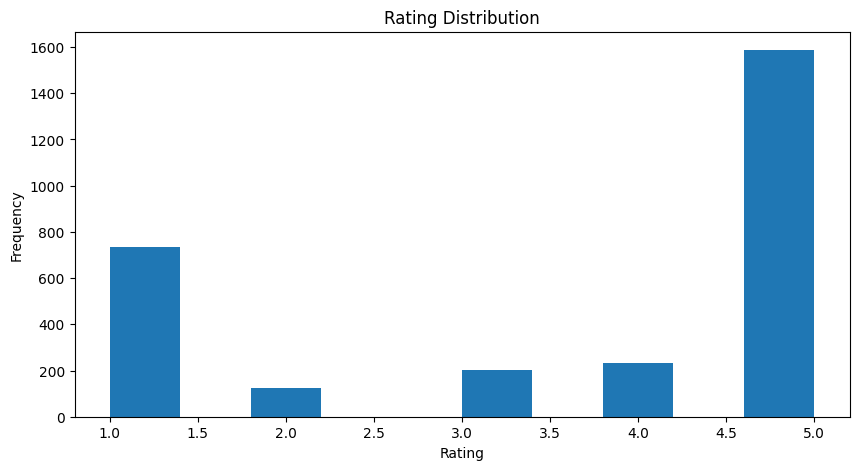

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(df["rating"].dropna())
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show

# Rating distribution

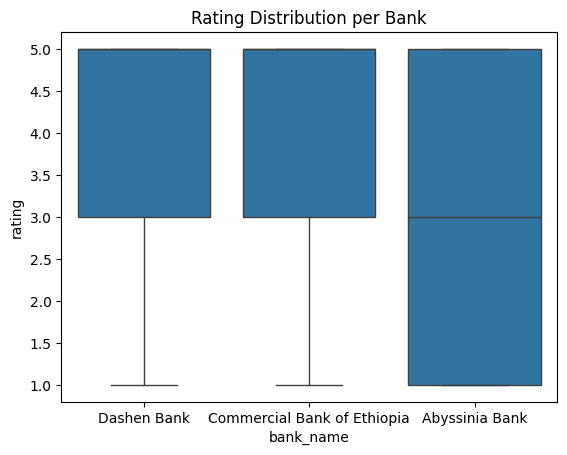

In [31]:
sns.boxplot(data=df, x='bank_name', y='rating')
plt.title("Rating Distribution per Bank")
plt.show()


# SENTIMENT DISTRIBUTION PER BANK

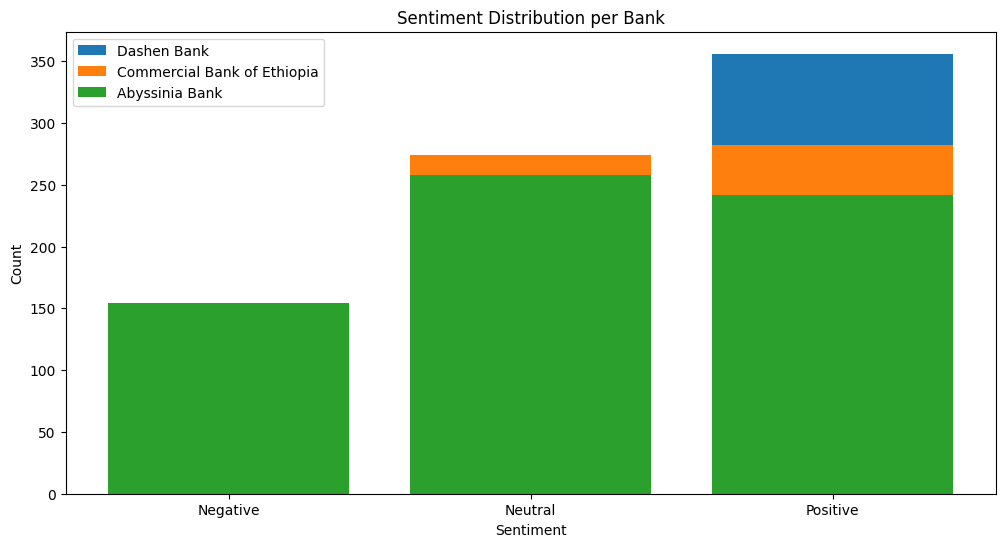

In [32]:
sentiment_counts = df.groupby(["bank_name", "sentiment"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))

for bank in df["bank_name"].unique():
    bank_data = sentiment_counts[sentiment_counts["bank_name"] == bank]
    plt.bar(bank_data["sentiment"], bank_data["count"])

plt.title("Sentiment Distribution per Bank")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(df["bank_name"].unique())
plt.show()

#rating is numeric

In [97]:
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

#

In [98]:
avg_rating = df.groupby("bank_name")["rating"].mean().reset_index()
print("Average Rating Per Bank:")
print(avg_rating)

Average Rating Per Bank:
                     bank_name    rating
0               Abyssinia Bank  3.091743
1  Commercial Bank of Ethiopia  3.925566
2                  Dashen Bank  3.888889


#comparison

In [34]:


plt.figure(figsize=(8, 5))
plt.bar(sentinel["bank_name"], bank_sentiment["sentiment"]) # type: ignore
plt.xlabel("Bank")
plt.ylabel("Average Sentiment Score")
plt.title("Customer Sentiment Comparison Across Banks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: '_Sentinel' object is not subscriptable

<Figure size 800x500 with 0 Axes>